## Executive Summary

### For my analysis, I have scraped data from the past 7 MLB seasons (2009 - 2016). The data includes, for each game, each team's batting, pitching, and bullpen statistics.  I have built a model to predict the probability, that given these statistics, the game will hit the predetermined Over run total. The predetermined Over/Under score has been taken from Covers.com (Covers.com takes their data from Las Vegas feeds). I have quickly learned that Las Vegas is extremely good at predicting the over or under for a game. The final dataframe included statistics from  19,934 MLB games, of which a total of 9,678 (48%) have hit the over. 

### I have built an XGBoost Classifier that is extremely good at prediciting if the Over will occur, however not great at predicting if the Under will Occur.  

In [3]:
import pandas as pd
import numpy as np

In [4]:
df = pd.read_csv('../CapStone/LetsModelBaby.csv')
df.shape

/Users/elutins/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (40,41) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(19934, 60)

In [5]:
pd.options.display.max_columns = 999

In [6]:
df.drop('Unnamed: 0', axis=1, inplace=True)

In [12]:
df['Date'] = pd.to_datetime(df['Date'])

In [14]:
df.isnull().sum().sort_values(ascending=False)

Over hit?                 0
BattingTeam1_BB%          0
Pitcher2_WHIP             0
Pitcher2_ShO              0
Pitcher2_K%               0
Pitcher2_HR/9             0
Pitcher2_ERA              0
Pither2_CG                0
Pitcher2_BB%              0
Pitcher_Team2             0
Pitcher2                  0
BattingTeam1_SLG          0
BattingTeam1_OBP          0
BattingTeam1_K%           0
BattingTeam1_BABIP        0
BattingTeam2              0
BattingTeam1_AVG          0
BattingTeam1              0
BattingTeam1_RBIs/Game    0
Pitcher1_WHIP             0
Pitcher1_ShO              0
Pitcher1_K%               0
Pitcher1_HR/9             0
Pitcher1_ERA              0
Pither1_CG                0
Pitcher1_BB%              0
Pitcher_Team1             0
Pitcher1                  0
BattingTeam2_RBIs/Game    0
BattingTeam2_AVG          0
Bullpen2_ERA              0
Actual Away Starter       0
Bullpen2_HR/9             0
Bullpen2_WHIP             0
Bullpen2_BB%              0
Bullpen2_K%         

In [16]:
## CHECKING THE BASELINE SCORE OF HOW MANY TOTAL OVERS ARE IN THE DATAFRAME
df.loc[df['Over hit?'] == 1].shape

(9678, 59)

#### Baseline score for hitting the over is roughly 50%, suggesting we do not need to worry about unbalanced classes

### Now That Binary Outcome Column Has Been Set, Can Start Modeling

#### Setting the X and y

In [32]:
# ESTABLISHING THE X AND Y FOR THE MODEL. X WILL INCLUDE ALL STATISTICS FROM BOTH BATTING TEAMS AND BOTH PITCHING TEAMS
X = df.drop(['Date', 'Pitcher1','Pitcher_Team1', 'Pitcher_Team2', 'BattingTeam1', 'BattingTeam2', 'Pitcher2',
        'Pitcher_Team2', 'BattingTeam2', 'Line', 'Opponent_y', 'Over/Under', 'Score', 'Game Line', 'O/U', 'O/U Game Result',
        'Total Runs in Game', 'Win/Loss Game', 'Actual Away Starter', 'Actual Home Starter', 'Bullpen_Team1', 'Bullpen_Team2', 'Over hit?'], axis=1)

y = df['Over hit?']

In [23]:
len(X.columns)

38

#### Function for printing confusion matrix: 

In [3]:
# # import some data to play with
# class_names = y.unique()

# # Split the data into a training set and a test set
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =.33, stratify=y)

# # Run classifier, using a model that is too regularized (C too low) to see
# # the impact on the results
# classifier = svm.SVC(kernel='rbf', gamma=100.0, C=10.0)
# y_pred = classifier.fit(X_train, y_train).predict(X_test)


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# # Compute confusion matrix
# cnf_matrix = confusion_matrix(y_test, test_preds)
# np.set_printoptions(precision=2)

# # Plot non-normalized confusion matrix
# plt.figure()
# plot_confusion_matrix(cnf_matrix, classes=class_names,
#                       title='Confusion matrix, without normalization')

# # Plot normalized confusion matrix
# plt.figure()
# plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
#                       title='Normalized confusion matrix')

# plt.show()

## XGBoost Model

In [29]:
from xgboost import XGBClassifier 

In [45]:
XGBClassifier().get_params

<bound method XGBClassifier.get_params of XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)>

In [51]:
model = XGBClassifier()

# setting up xgboost parameters
max_depth = np.arange(9, step=2)
gamma_range = 10.**np.arange(-1, 4)
n_estimators = [4, 8, 12, 16]
min_child_weight = np.arange(0,3)


# setting up GridSearch
grid = GridSearchCV(estimator=model, cv=5, scoring='accuracy', param_grid=dict(max_depth=max_depth, 
                                                                              n_estimators=n_estimators,
                                                                              gamma=gamma_range,
                                                                              min_child_weight = min_child_weight))

# fitting model
grid.fit(X, y)

print grid.best_score_
print grid.best_params_

0.51695595465
{'n_estimators': 4, 'max_depth': 4, 'gamma': 100.0, 'min_child_weight': 0}


In [81]:
grid.grid_scores_

[mean: 0.51450, std: 0.00006, params: {'n_estimators': 4, 'max_depth': 0, 'gamma': 0.10000000000000001, 'min_child_weight': 0},
 mean: 0.51450, std: 0.00006, params: {'n_estimators': 8, 'max_depth': 0, 'gamma': 0.10000000000000001, 'min_child_weight': 0},
 mean: 0.51450, std: 0.00006, params: {'n_estimators': 12, 'max_depth': 0, 'gamma': 0.10000000000000001, 'min_child_weight': 0},
 mean: 0.51450, std: 0.00006, params: {'n_estimators': 16, 'max_depth': 0, 'gamma': 0.10000000000000001, 'min_child_weight': 0},
 mean: 0.51450, std: 0.00006, params: {'n_estimators': 4, 'max_depth': 0, 'gamma': 0.10000000000000001, 'min_child_weight': 1},
 mean: 0.51450, std: 0.00006, params: {'n_estimators': 8, 'max_depth': 0, 'gamma': 0.10000000000000001, 'min_child_weight': 1},
 mean: 0.51450, std: 0.00006, params: {'n_estimators': 12, 'max_depth': 0, 'gamma': 0.10000000000000001, 'min_child_weight': 1},
 mean: 0.51450, std: 0.00006, params: {'n_estimators': 16, 'max_depth': 0, 'gamma': 0.100000000000000

#### This has brought back the highest ROC_AUC Score Yet of .72. Parameters of XGBoost are:
- n_estimators=20
- max_depth=4 
- gamma=10.0
- min_child_weight=0

In [176]:
model = XGBClassifier(n_estimators=20, max_depth=4, gamma=10.0, min_child_weight=0)

model.fit(X_train, y_train)

y_preds = model.predict_proba(X_test)



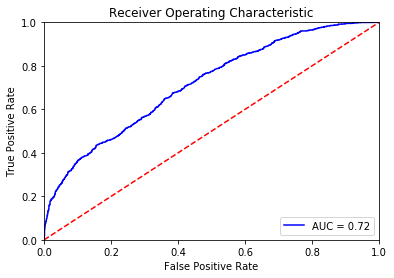

In [135]:
fpr, tpr, threshold = roc_curve(y_test, y_preds[:,1])
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic');
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc);
plt.legend(loc = 'lower right');
plt.plot([0, 1], [0, 1],'r--');
plt.xlim([0, 1]);
plt.ylim([0, 1]);
plt.ylabel('True Positive Rate');
plt.xlabel('False Positive Rate');

In [143]:
from sklearn.metrics import accuracy_score

In [74]:
pd.DataFrame(y_preds)
# pd.DataFrame(X_test, y_test, y_preds)

,0,1
0,0.450414,0.549586
1,0.477437,0.522563
2,0.558246,0.441754
3,0.504688,0.495312
4,0.549542,0.450458
5,0.449672,0.550328
6,0.499708,0.500292
7,0.381693,0.618307
8,0.213667,0.786333
9,0.191814,0.808186


In [64]:
model.score

<bound method XGBClassifier.score of XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=10.0, learning_rate=0.1, max_delta_step=0, max_depth=4,
       min_child_weight=0, missing=None, n_estimators=20, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)>

In [36]:
from sklearn.metrics import roc_curve

In [38]:
from sklearn.metrics import auc

## Feature Engineering

In [48]:
# MAKING NEW COLUMNS FOR COMBINED STARTING PITCHER STATS, COMBINED BULLPEN STATS, AND COMBINED BATTING STATS
df.head()

,Date,Pitcher1,Pitcher_Team1,Pitcher1_BB%,Pither1_CG,Pitcher1_ERA,Pitcher1_HR/9,Pitcher1_K%,Pitcher1_ShO,Pitcher1_WHIP,BattingTeam1_RBIs/Game,BattingTeam1,BattingTeam1_AVG,BattingTeam1_BABIP,BattingTeam1_BB%,BattingTeam1_K%,BattingTeam1_OBP,BattingTeam1_SLG,Pitcher2,Pitcher_Team2,Pitcher2_BB%,Pither2_CG,Pitcher2_ERA,Pitcher2_HR/9,Pitcher2_K%,Pitcher2_ShO,Pitcher2_WHIP,BattingTeam2_RBIs/Game,BattingTeam2,BattingTeam2_AVG,BattingTeam2_BABIP,BattingTeam2_BB%,BattingTeam2_K%,BattingTeam2_OBP,BattingTeam2_SLG,Line,Opponent_y,Over/Under,Score,Game Line,O/U,O/U Game Result,Total Runs in Game,Win/Loss Game,Actual Away Starter,Actual Home Starter,Bullpen_Team1,Bullpen1_K%,Bullpen1_BB%,Bullpen1_WHIP,Bullpen1_HR/9,Bullpen1_ERA,Bullpen_Team2,Bullpen2_K%,Bullpen2_BB%,Bullpen2_WHIP,Bullpen2_HR/9,Bullpen2_ERA,Over hit?
0,2016-05-19,Mike Foltynewicz,ATL,0.026316,0.0,2.967033,1.978022,0.210526,0,1.208791,4.692308,PIT,0.279680,0.334300,0.095481,0.197327,0.358793,0.430444,Jeff Locke,PIT,0.122093,0.0,5.549598,1.206434,0.145349,0,1.689008,3.076923,ATL,0.235913,0.297324,0.074848,0.214430,0.298976,0.317055,L 162,PIT,O 8 -104,L 2-8,162,8,O,10.0,L,Mike Foltynewicz,Jeff Locke,ATL,0.243243,0.109797,1.588933,0.996047,4.980237,PIT,0.185059,0.108659,1.520062,1.180556,4.583333,1
1,2016-07-10,Mike Foltynewicz,ATL,0.061453,0.0,4.433498,2.438424,0.195531,0,1.354680,4.011494,CHW,0.251183,0.299223,0.080254,0.214416,0.317504,0.402975,James Shields,CHW,0.102381,0.0,5.784314,1.568627,0.173810,0,1.677560,3.261364,ATL,0.237131,0.287892,0.073069,0.204295,0.300362,0.347725,W 146,CHW,U 9.5 101,W 2-0,146,9.5,U,2.0,W,Mike Foltynewicz,James Shields,ATL,0.228507,0.111614,1.525952,0.840830,4.391003,CHW,0.214349,0.110717,1.513426,0.549227,3.624898,0
2,2016-07-21,Mike Foltynewicz,ATL,0.056522,0.0,3.791209,1.813187,0.217391,0,1.208791,4.851064,COL,0.270429,0.320303,0.081418,0.212130,0.333427,0.452667,Chad Bettis,COL,0.057971,0.0,5.721063,1.195446,0.175983,0,1.537002,3.200000,ATL,0.237377,0.286578,0.073582,0.202213,0.300615,0.349446,W -155,ATL,U 12 -118,W 7-3,-155,12,U,10.0,W,Mike Foltynewicz,Chad Bettis,ATL,0.225511,0.109937,1.531764,0.841664,4.353434,COL,0.201637,0.080357,1.478232,1.214985,5.133311,0
3,2016-07-27,Mike Foltynewicz,ATL,0.070588,0.0,3.913043,1.806020,0.215686,0,1.254181,4.161616,MIN,0.250220,0.298345,0.080981,0.223424,0.315413,0.412628,Tyler Duffey,MIN,0.056122,0.0,5.908558,1.582649,0.178571,0,1.512309,3.170000,ATL,0.237089,0.286372,0.074757,0.201632,0.301118,0.349472,W 146,MIN,O 8.5 112,W 9-7,146,8.5,O,16.0,W,Mike Foltynewicz,Tyler Duffey,ATL,0.226326,0.108798,1.523342,0.912162,4.422604,MIN,0.224877,0.074491,1.464194,1.438619,4.632353,1
4,2016-08-12,Mike Foltynewicz,ATL,0.069277,0.0,4.500000,1.539474,0.198795,0,1.342105,4.557522,WSN,0.251692,0.284126,0.089991,0.197429,0.325092,0.427902,Stephen Strasburg,WSN,0.071298,0.0,2.845588,0.860294,0.308958,0,1.029412,3.356522,ATL,0.244393,0.293493,0.075377,0.198492,0.307692,0.361366,W 210,WAS,O 7.5 -106,W 8-5,210,7.5,O,13.0,W,Mike Foltynewicz,Stephen Strasburg,ATL,0.225262,0.110012,1.469506,0.828076,4.140379,WSN,0.255708,0.079909,1.220372,0.807175,3.084561,1


In [58]:
# making new columns
df['Combined_SP_BB%'] = df['Pitcher1_BB%'] + df['Pitcher2_BB%']
df['Combined_SP_ERA'] = df['Pitcher1_ERA'] + df['Pitcher2_ERA']
df['Combined_SP_HR/9'] = df['Pitcher1_HR/9'] + df['Pitcher2_HR/9']
df['Combined_SP_K%'] = df['Pitcher1_K%'] + df['Pitcher2_K%']
df['Combined_SP_WHIP'] = df['Pitcher1_WHIP'] + df['Pitcher2_WHIP']
df['Combined_RBIs/Game'] = df['BattingTeam1_RBIs/Game'] + df['BattingTeam2_RBIs/Game']
df['Combined_Bat_AVG'] = df['BattingTeam1_AVG'] + df['BattingTeam2_AVG']
df['Combined_Bat_BABIP'] = df['BattingTeam1_BABIP'] + df['BattingTeam2_BABIP']
df['Combined_Bat_BB%'] = df['BattingTeam1_BB%'] + df['BattingTeam2_BB%']
df['Combined_Bat_K%'] = df['BattingTeam1_K%'] + df['BattingTeam2_K%']
df['Combined_Bat_OBP'] = df['BattingTeam1_OBP'] + df['BattingTeam2_OBP']
df['Combined_bat_slg'] = df['BattingTeam1_SLG'] + df['BattingTeam2_SLG']
df['Combined_bullpen_k%'] = df['Bullpen1_K%'] + df['Bullpen2_K%']
df['combined_bp_bb%'] = df['Bullpen1_BB%'] + df['Bullpen2_BB%']
df['combnied_bp_WHIP'] = df['Bullpen1_WHIP'] + df['Bullpen2_WHIP']
df['combined_bp_HR/9'] = df['Bullpen1_HR/9'] + df['Bullpen2_HR/9']
df['combined_bp_ERA'] = df['Bullpen1_ERA'] + df['Bullpen2_ERA']


In [59]:
df.head()

,Date,Pitcher1,Pitcher_Team1,Pitcher1_BB%,Pither1_CG,Pitcher1_ERA,Pitcher1_HR/9,Pitcher1_K%,Pitcher1_ShO,Pitcher1_WHIP,BattingTeam1_RBIs/Game,BattingTeam1,BattingTeam1_AVG,BattingTeam1_BABIP,BattingTeam1_BB%,BattingTeam1_K%,BattingTeam1_OBP,BattingTeam1_SLG,Pitcher2,Pitcher_Team2,Pitcher2_BB%,Pither2_CG,Pitcher2_ERA,Pitcher2_HR/9,Pitcher2_K%,Pitcher2_ShO,Pitcher2_WHIP,BattingTeam2_RBIs/Game,BattingTeam2,BattingTeam2_AVG,BattingTeam2_BABIP,BattingTeam2_BB%,BattingTeam2_K%,BattingTeam2_OBP,BattingTeam2_SLG,Line,Opponent_y,Over/Under,Score,Game Line,O/U,O/U Game Result,Total Runs in Game,Win/Loss Game,Actual Away Starter,Actual Home Starter,Bullpen_Team1,Bullpen1_K%,Bullpen1_BB%,Bullpen1_WHIP,Bullpen1_HR/9,Bullpen1_ERA,Bullpen_Team2,Bullpen2_K%,Bullpen2_BB%,Bullpen2_WHIP,Bullpen2_HR/9,Bullpen2_ERA,Over hit?,Combined_SP_BB%,Combined_SP_ERA,Combined_SP_HR/9,Combined_SP_K%,Combined_SP_WHIP,Combined_RBIs/Game,Combined_Bat_AVG,Combined_Bat_BABIP,Combined_Bat_BB%,Combined_Bat_K%,Combined_Bat_OBP,Combined_bat_slg,Combined_bullpen_k%,combined_bp_bb%,combnied_bp_WHIP,combined_bp_HR/9,combined_bp_ERA
0,2016-05-19,Mike Foltynewicz,ATL,0.026316,0.0,2.967033,1.978022,0.210526,0,1.208791,4.692308,PIT,0.279680,0.334300,0.095481,0.197327,0.358793,0.430444,Jeff Locke,PIT,0.122093,0.0,5.549598,1.206434,0.145349,0,1.689008,3.076923,ATL,0.235913,0.297324,0.074848,0.214430,0.298976,0.317055,L 162,PIT,O 8 -104,L 2-8,162,8,O,10.0,L,Mike Foltynewicz,Jeff Locke,ATL,0.243243,0.109797,1.588933,0.996047,4.980237,PIT,0.185059,0.108659,1.520062,1.180556,4.583333,1,0.148409,8.516631,3.184456,0.355875,2.897799,7.769231,0.515592,0.631624,0.170329,0.411757,0.657769,0.747499,0.428303,0.218456,3.108995,2.176603,9.563570
1,2016-07-10,Mike Foltynewicz,ATL,0.061453,0.0,4.433498,2.438424,0.195531,0,1.354680,4.011494,CHW,0.251183,0.299223,0.080254,0.214416,0.317504,0.402975,James Shields,CHW,0.102381,0.0,5.784314,1.568627,0.173810,0,1.677560,3.261364,ATL,0.237131,0.287892,0.073069,0.204295,0.300362,0.347725,W 146,CHW,U 9.5 101,W 2-0,146,9.5,U,2.0,W,Mike Foltynewicz,James Shields,ATL,0.228507,0.111614,1.525952,0.840830,4.391003,CHW,0.214349,0.110717,1.513426,0.549227,3.624898,0,0.163833,10.217811,4.007051,0.369340,3.032240,7.272858,0.488314,0.587115,0.153323,0.418710,0.617866,0.750700,0.442856,0.222331,3.039377,1.390057,8.015902
2,2016-07-21,Mike Foltynewicz,ATL,0.056522,0.0,3.791209,1.813187,0.217391,0,1.208791,4.851064,COL,0.270429,0.320303,0.081418,0.212130,0.333427,0.452667,Chad Bettis,COL,0.057971,0.0,5.721063,1.195446,0.175983,0,1.537002,3.200000,ATL,0.237377,0.286578,0.073582,0.202213,0.300615,0.349446,W -155,ATL,U 12 -118,W 7-3,-155,12,U,10.0,W,Mike Foltynewicz,Chad Bettis,ATL,0.225511,0.109937,1.531764,0.841664,4.353434,COL,0.201637,0.080357,1.478232,1.214985,5.133311,0,0.114493,9.512271,3.008633,0.393375,2.745793,8.051064,0.507805,0.606881,0.155000,0.414343,0.634042,0.802113,0.427148,0.190294,3.009995,2.056649,9.486745
3,2016-07-27,Mike Foltynewicz,ATL,0.070588,0.0,3.913043,1.806020,0.215686,0,1.254181,4.161616,MIN,0.250220,0.298345,0.080981,0.223424,0.315413,0.412628,Tyler Duffey,MIN,0.056122,0.0,5.908558,1.582649,0.178571,0,1.512309,3.170000,ATL,0.237089,0.286372,0.074757,0.201632,0.301118,0.349472,W 146,MIN,O 8.5 112,W 9-7,146,8.5,O,16.0,W,Mike Foltynewicz,Tyler Duffey,ATL,0.226326,0.108798,1.523342,0.912162,4.422604,MIN,0.224877,0.074491,1.464194,1.438619,4.632353,1,0.126711,9.821602,3.388670,0.394258,2.766490,7.331616,0.487309,0.584717,0.155738,0.425056,0.616531,0.762100,0.451203,0.183288,2.987536,2.350781,9.054957
4,2016-08-12,Mike Foltynewicz,ATL,0.069277,0.0,4.500000,1.539474,0.198795,0,1.342105,4.557522,WSN,0.251692,0.284126,0.089991,0.197429,0.325092,0.427902,Stephen Strasburg,WSN,0.071298,0.0,2.845588,0.860294,0.308958,0,1.029412,3.356522,ATL,0.244393,0.293493,0.075377,0.198492,0.307692,0.361366,W 210,WAS,O 7.5 -106,W 8-5,210,7.5,O,13.0,W,Mike Foltynewicz,Stephen Strasburg,ATL,0.225262,0.110012,1.469506,0.828076,4.140379,WSN,0.255708,0.079909,1.22037

In [85]:
# ESTABLISHING THE X AND Y FOR THE MODEL. X WILL INCLUDE ALL STATISTICS FROM BOTH BATTING TEAMS AND BOTH PITCHING TEAMS
X = df.drop(['Date', 'Pitcher1','Pitcher_Team1', 'Pitcher_Team2', 'BattingTeam1', 'BattingTeam2', 'Pitcher2',
        'Pitcher_Team2', 'BattingTeam2', 'Line', 'Opponent_y', 'Over/Under', 'Score', 'Game Line', 'O/U', 'O/U Game Result',
        'Total Runs in Game', 'Win/Loss Game', 'Actual Away Starter', 'Actual Home Starter', 'Bullpen_Team1', 'Bullpen_Team2', 'Over hit?'], axis=1)

y = df['Over hit?']

In [86]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =.33)

In [185]:
model = XGBClassifier(n_estimators=20, max_depth=4, gamma=10.0, min_child_weight=0)

model.fit(X_train, y_train)

y_preds = model.predict(X_test)


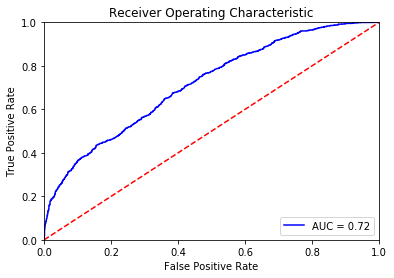

In [183]:
fpr, tpr, threshold = roc_curve(y_test, y_pred[:,1])
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic');
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc);
plt.legend(loc = 'lower right');
plt.plot([0, 1], [0, 1],'r--');
plt.xlim([0, 1]);
plt.ylim([0, 1]);
plt.ylabel('True Positive Rate');
plt.xlabel('False Positive Rate');

Confusion matrix, without normalization
[[2424  961]
 [1433 1761]]
Normalized confusion matrix
[[ 0.72  0.28]
 [ 0.45  0.55]]


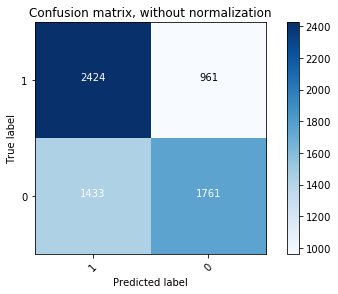

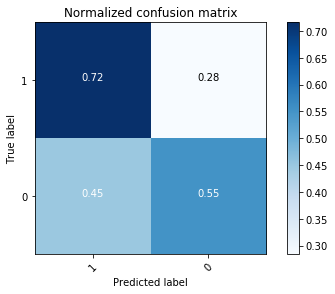

In [187]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_preds)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

## Random Forest Classifier

In [161]:
from sklearn.ensemble import RandomForestClassifier

In [170]:
clf = RandomForestClassifier()

# setting grid-searching parameters:
n_estimators = [1,2,4,8,10]
criterion = ['gini', 'entropy']
max_features = ['auto', 'log2', 3, 8]
max_depth = [1,2,4, 8]

grid = GridSearchCV(estimator=clf, cv=5, scoring='roc_auc', param_grid=dict(n_estimators=n_estimators,
                                                                             criterion=criterion,
                                                                             max_features=max_features,
                                                                             max_depth=max_depth))

grid.fit(X, y)

print grid.best_score_
print grid.best_params_

0.529735357624
{'max_features': 'auto', 'n_estimators': 4, 'criterion': 'gini', 'max_depth': 2}


In [188]:
model = RandomForestClassifier(max_features='auto', n_estimators=4, criterion='gini', max_depth=2)

model.fit(X_train, y_train)

y_preds = model.predict(X_test)

In [179]:
confusion_matrix(y_test, y_preds)

array([[2836,  549],
       [2258,  936]])

Confusion matrix, without normalization
[[2836  549]
 [2258  936]]
Normalized confusion matrix
[[ 0.84  0.16]
 [ 0.71  0.29]]


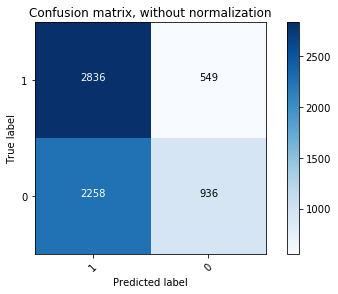

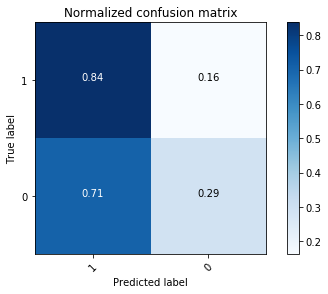

In [181]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_preds)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [189]:
accuracy_score(y_test, y_preds)

0.56239550083599332

## Logistic Regression

In [83]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LogisticRegression

In [87]:
# running simple Logistic Regression Before Grid Searching to see how well model performs
model = LogisticRegression()

model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [92]:
y_preds = model.predict(X_test)

array([0, 1, 0, ..., 0, 1, 1])

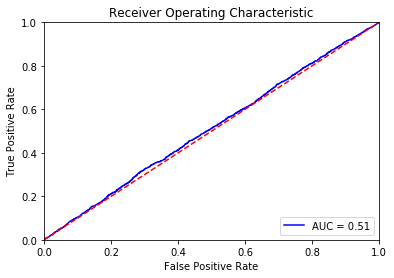

In [93]:
fpr, tpr, threshold = roc_curve(y_test, y_preds[:,1])
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic');
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc);
plt.legend(loc = 'lower right');
plt.plot([0, 1], [0, 1],'r--');
plt.xlim([0, 1]);
plt.ylim([0, 1]);
plt.ylabel('True Positive Rate');
plt.xlabel('False Positive Rate');

In [112]:
## GRIDSEARCHING LOGISTIC REGRESSION
model = LogisticRegression()

# establishing parameters to gridsearch
penalty = ['l1', 'l2']
C = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
class_weights = ['balanced', None]


grid = GridSearchCV(estimator=model, cv=5, scoring='accuracy', param_grid=dict(penalty=penalty,
                                                                              C=C,
                                                                              class_weight = class_weights))


grid.fit(X,y)

print grid.best_score_
print grid.best_params_

0.514497842882
{'penalty': 'l1', 'C': 0.001, 'class_weight': 'balanced'}


In [114]:
model = LogisticRegression(penalty = 'l1', C=.001, class_weight='balanced')

model.fit(X_train, y_train)

preds = model.predict_proba(X_test)

In [118]:
y_pred = model.fit(X_train, y_train).predict(X_test)


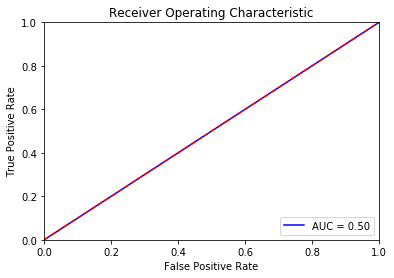

In [115]:
fpr, tpr, threshold = roc_curve(y_test, preds[:,1])
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic');
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc);
plt.legend(loc = 'lower right');
plt.plot([0, 1], [0, 1],'r--');
plt.xlim([0, 1]);
plt.ylim([0, 1]);
plt.ylabel('True Positive Rate');
plt.xlabel('False Positive Rate');

In [122]:
import itertools

Confusion matrix, without normalization
[[3385    0]
 [3194    0]]
Normalized confusion matrix
[[ 1.  0.]
 [ 1.  0.]]


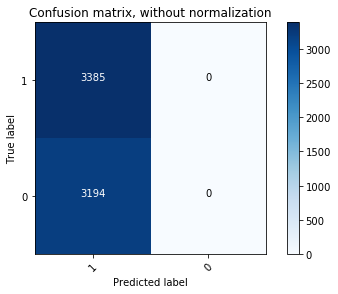

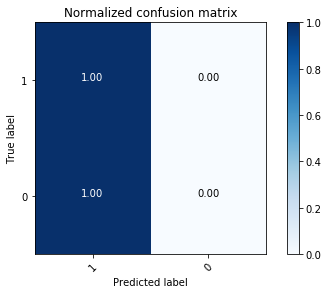

In [123]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

## Applying PCA

In [104]:
# We need to center before PCA
# Choosing not to standardize the Data. I do not believe that the importance of features is independent of feature 
# variance
pca_X = (X - X.mean())


# Assuring the variables have a mean of 0
np.round(pca_X.mean(),5)



#subjective = (subjective - subjective.mean()) / subjective.std()

Pitcher1_BB%              0.0
Pither1_CG                0.0
Pitcher1_ERA             -0.0
Pitcher1_HR/9            -0.0
Pitcher1_K%              -0.0
Pitcher1_ShO             -0.0
Pitcher1_WHIP             0.0
BattingTeam1_RBIs/Game   -0.0
BattingTeam1_AVG          0.0
BattingTeam1_BABIP        0.0
BattingTeam1_BB%          0.0
BattingTeam1_K%          -0.0
BattingTeam1_OBP         -0.0
BattingTeam1_SLG          0.0
Pitcher2_BB%              0.0
Pither2_CG                0.0
Pitcher2_ERA              0.0
Pitcher2_HR/9            -0.0
Pitcher2_K%               0.0
Pitcher2_ShO              0.0
Pitcher2_WHIP            -0.0
BattingTeam2_RBIs/Game    0.0
BattingTeam2_AVG         -0.0
BattingTeam2_BABIP       -0.0
BattingTeam2_BB%         -0.0
BattingTeam2_K%           0.0
BattingTeam2_OBP         -0.0
BattingTeam2_SLG          0.0
Bullpen1_K%               0.0
Bullpen1_BB%             -0.0
Bullpen1_WHIP            -0.0
Bullpen1_HR/9             0.0
Bullpen1_ERA              0.0
Bullpen2_K

In [94]:
from sklearn.decomposition import PCA

In [95]:
## Initialize the PCA from SKLearn. We'll use 10 components to start with
pca = PCA(n_components=8)

In [105]:
# Fitting the PCA
pca.fit(pca_X.values)


PCA(copy=True, iterated_power='auto', n_components=8, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [107]:
## Return the loadings for each of the components
pca_components = pca.components_
pca_components


array([[  9.83801431e-04,  -2.08389786e-05,   3.18354514e-01,
          7.60749167e-02,  -3.03194321e-03,   2.06158691e-04,
          4.09186873e-02,   8.84107596e-03,   3.66020043e-04,
          3.78388069e-04,   5.33511948e-06,  -1.72855829e-04,
          3.39172504e-04,   6.59114485e-04,   2.03955737e-03,
         -8.76179790e-04,   4.60316800e-01,   1.18029171e-01,
         -4.13956110e-03,  -6.94924098e-04,   6.76837590e-02,
          1.42332317e-02,   3.55032058e-04,   1.91193005e-04,
          5.95942881e-05,  -3.06376161e-04,   3.42423785e-04,
          9.10031960e-04,  -5.05988316e-04,   1.28164282e-04,
          3.54958779e-03,   6.33267674e-03,   2.45690656e-02,
         -7.82763080e-04,   1.67946609e-04,   4.41927113e-03,
          7.06120512e-03,   2.51291066e-02,   3.02335880e-03,
          7.78671314e-01,   1.94104088e-01,  -7.17150431e-03,
          1.08602446e-01,   2.30743076e-02,   7.21052102e-04,
          5.69581075e-04,   6.49294076e-05,  -4.79231990e-04,
        

In [108]:
## Return the loadings for each PCA, along with the column names that corresponding to each loading.

# print pca_X.columns
# print '-------------------------------------'

for i, pc in enumerate(['PC1','PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8']):
    print pc, 'weighting vector:', pca_components[i]
    print '-------------------------------------' 




# print subjective_cols
# print '-------------------------------------'

# for i, pc in enumerate(['PC1','PC2','PC3','PC4','PC5']):
#     print pc, 'weighting vector:', subj_components[i]
#     print '-------------------------------------'

PC1 weighting vector: [  9.83801431e-04  -2.08389786e-05   3.18354514e-01   7.60749167e-02
  -3.03194321e-03   2.06158691e-04   4.09186873e-02   8.84107596e-03
   3.66020043e-04   3.78388069e-04   5.33511948e-06  -1.72855829e-04
   3.39172504e-04   6.59114485e-04   2.03955737e-03  -8.76179790e-04
   4.60316800e-01   1.18029171e-01  -4.13956110e-03  -6.94924098e-04
   6.76837590e-02   1.42332317e-02   3.55032058e-04   1.91193005e-04
   5.95942881e-05  -3.06376161e-04   3.42423785e-04   9.10031960e-04
  -5.05988316e-04   1.28164282e-04   3.54958779e-03   6.33267674e-03
   2.45690656e-02  -7.82763080e-04   1.67946609e-04   4.41927113e-03
   7.06120512e-03   2.51291066e-02   3.02335880e-03   7.78671314e-01
   1.94104088e-01  -7.17150431e-03   1.08602446e-01   2.30743076e-02
   7.21052102e-04   5.69581075e-04   6.49294076e-05  -4.79231990e-04
   6.81596289e-04   1.56914644e-03  -1.28875140e-03   2.96110891e-04
   7.96885892e-03   1.33938819e-02   4.96981722e-02]
----------------------------

In [109]:
## Return the eigenvalues and the explained variance.
## NOTE: In sklearn, explained_variance_ returns the eigenvalues
## while explained_variance_ratio_ gives us the actual explained variance.

exp_var_eigenvals = pca.explained_variance_
exp_var_pct = pca.explained_variance_ratio_

print 'eigenvalues:', exp_var_eigenvals
print ''
print 'explained variance pct:', exp_var_pct
print ''
print exp_var_pct.sum()







# ## Call transform on the values. This will actually apply the PCA transformation to the data.

#subj_to_pcs = subjective_pca.transform(subjective.values)

eigenvalues: [ 10.94626648   3.38341825   1.75545136   0.85572716   0.76135923
   0.50641007   0.25197553   0.22622361]

explained variance pct: [ 0.5765927   0.17822097  0.0924681   0.04507528  0.04010447  0.02667506
  0.01327277  0.01191629]

0.984325636409


In [110]:
## Calling transform on the values. This will apply the PCA transformation to the data.
data_to_pcs = pca.transform(X.values)



# subj_to_pcs = subjective_pca.transform(subjective.values)

#### Applying PCA Components to Logistic Regresion

In [111]:
# running a Logistic Regression on PCA Components
model = LogisticRegression()

scores = cross_val_score(model, data_to_pcs, y, cv=5, scoring='accuracy')

print scores
print scores.mean()


[ 0.49272818  0.51893654  0.4883371   0.43803312  0.49147015]
0.485901017059


In [115]:
# APPLYING THE PCA COMPONENTS TO AN XGB CLASSIFIER

model = XGBClassifier(n_estimators=20, max_depth=4, gamma=100.0, min_child_weight=0)

score = cross_val_score(model, data_to_pcs, y, scoring='roc_auc', cv=5)
print score
score.mean()


# model = XGBClassifier(n_estimators=20, max_depth=8, gamma=1.0, min_child_weight=1)

# pca_score = cross_val_score(model, data_to_pcs, y, scoring='roc_auc', cv=10)
# print pca_score
# pca_score.mean()

[ 0.52  0.5   0.49  0.5   0.5 ]


0.50054727594685056